<a href="https://colab.research.google.com/github/EstevaoDev/challengeTelecomX2/blob/main/challengeTelecomX2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving dados_tratados.csv to dados_tratados.csv


In [4]:
import pandas as pd
df = pd.read_csv('dados_tratados.csv')
df = pd.read_csv('dados_tratados.csv', sep=';', encoding='utf-8')

#EXPANÇÃO DE DICIONÁRIOS

In [18]:
customer_df = df['customer'].apply(pd.Series)
phone_df = df['phone'].apply(pd.Series)
internet_df = df['internet'].apply(pd.Series)
account_df = df['account'].apply(pd.Series)
charges_df = account_df['Charges'].apply(pd.Series)

df_final = pd.concat([
    df.drop(columns=['customer', 'phone', 'internet', 'account']),
    customer_df, phone_df, internet_df,
    account_df.drop(columns=['Charges']),
    charges_df
], axis=1)

#REMOÇÃO DE COLUNAS


In [19]:
# Identificar colunas com dicionários
dict_cols = [col for col in df_model.columns if df_model[col].apply(lambda x: isinstance(x, dict)).any()]

# Excluir essas colunas da verificação de variabilidade
cols_to_check = [col for col in df_model.columns if col not in dict_cols]

In [20]:
for col in cols_to_check:
    if df_model[col].nunique() == 1:
        print(f"Removendo coluna sem variabilidade: {col}")
        df_model.drop(columns=[col], inplace=True)

In [21]:
# Criar uma cópia do DataFrame original tratado
df_model = df.copy()

# 1. Remover identificadores únicos
if 'customerID' in df_model.columns:
    df_model.drop(columns=['customerID'], inplace=True)

# 2. Identificar colunas com dicionários
dict_cols = [col for col in df_model.columns if df_model[col].apply(lambda x: isinstance(x, dict)).any()]

# 3. Verificar colunas com variabilidade nula (mesmo valor em todas as linhas)
for col in df_model.columns:
    if col not in dict_cols:
        if df_model[col].nunique() == 1:
            print(f"Removendo coluna sem variabilidade: {col}")
            df_model.drop(columns=[col], inplace=True)

# 4. Verificar colunas com valor único por linha (ex: identificadores disfarçados)
for col in df_model.columns:
    if col not in dict_cols:
        if df_model[col].nunique() == df_model.shape[0]:
            print(f"Removendo coluna com valor único por linha: {col}")
            df_model.drop(columns=[col], inplace=True)

#ENCONDING


In [23]:
# Copiar o DataFrame limpo
df_encoded = df_model.copy()

# Identificar colunas categóricas (excluindo dicionários)
categorical_cols = [col for col in df_encoded.columns
                    if df_encoded[col].dtype == 'object' and
                    not df_encoded[col].apply(lambda x: isinstance(x, dict)).any()]

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df_final, drop_first=True)

#PROPORÇÃO DE EVASÃO

In [24]:
# Contagem absoluta
churn_counts = df_model['Churn'].value_counts()

# Proporção relativa
churn_proportions = df_model['Churn'].value_counts(normalize=True)

# Exibir resultados
print("Contagem de clientes por classe:")
print(churn_counts)
print("\nProporção de clientes por classe:")
print(churn_proportions)

Contagem de clientes por classe:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Proporção de clientes por classe:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


#BALANCEAMENTO DE CLASSES


In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X = df_encoded.drop(columns=['Churn_Yes'])
y = df_encoded['Churn_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.86      0.87      0.86      1620
        True       0.61      0.59      0.60       561

    accuracy                           0.80      2181
   macro avg       0.73      0.73      0.73      2181
weighted avg       0.80      0.80      0.80      2181

Matriz de Confusão:
[[1408  212]
 [ 230  331]]
AUC-ROC: 0.8296


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# Aumentar o número de iterações
model = LogisticRegression(max_iter=2000)

# Ou escalar os dados
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_bal_scaled, y_train_bal)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# AUC-ROC
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.85      0.82      0.83      1620
        True       0.53      0.59      0.56       561

    accuracy                           0.76      2181
   macro avg       0.69      0.70      0.70      2181
weighted avg       0.77      0.76      0.76      2181

Matriz de Confusão:
[[1322  298]
 [ 229  332]]
AUC-ROC: 0.7858948966792105


In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Ajustar threshold
threshold = 0.4  # experimente com 0.4 ou 0.35
y_pred_thresh = (y_prob >= threshold).astype(int)

# Avaliação com novo threshold
print(classification_report(y_test, y_pred_thresh))
print(confusion_matrix(y_test, y_pred_thresh))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))  # continua igual, pois depende de y_prob

              precision    recall  f1-score   support

       False       0.87      0.79      0.83      1620
        True       0.52      0.66      0.58       561

    accuracy                           0.76      2181
   macro avg       0.69      0.72      0.70      2181
weighted avg       0.78      0.76      0.76      2181

[[1281  339]
 [ 193  368]]
AUC-ROC: 0.7858948966792105


#NORMALIZAÇÃO/ PADRONIZAÇÃO

In [30]:
from sklearn.preprocessing import StandardScaler

model_name = "logistic"  # ou "random_forest", "xgboost", etc.

if model_name in ["logistic", "svm", "knn", "mlp"]:
    scaler = StandardScaler()
    X_train_bal_scaled = scaler.fit_transform(X_train_bal)
    X_test_scaled = scaler.transform(X_test)
else:
    X_train_bal_scaled = X_train_bal
    X_test_scaled = X_test

#ANÁLISE DE CORRELAÇÃO


📈 Correlação com Churn:
Churn              1.000000
Monthly            0.193356
Charges.Monthly    0.193356
SeniorCitizen      0.150889
tenure            -0.352229
Name: Churn, dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


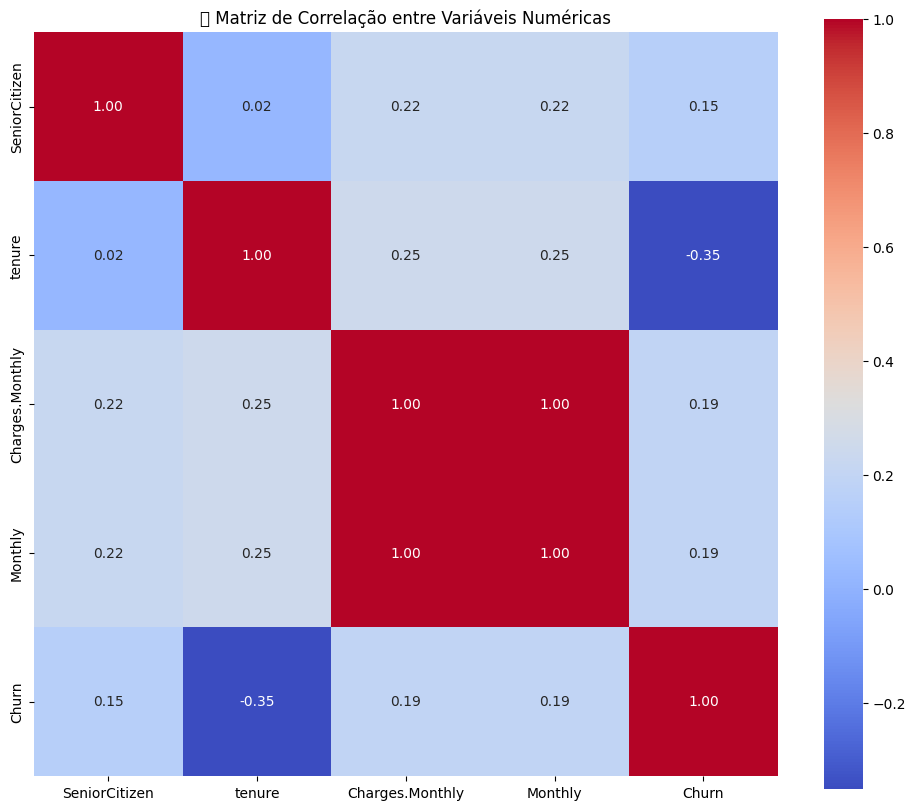

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# 1. Carregar o CSV
df = pd.read_csv("dados_tratados.csv")

# 2. Converter strings de dicionário em dicionários reais
for col in ['customer', 'phone', 'internet', 'account']:
    df[col] = df[col].apply(ast.literal_eval)

# 3. Expandir os dicionários em colunas
customer_df = pd.json_normalize(df['customer'])
phone_df = pd.json_normalize(df['phone'])
internet_df = pd.json_normalize(df['internet'])
account_df = pd.json_normalize(df['account'])

# 4. Extrair manualmente os valores de Charges
monthly_charges = []
total_charges = []

for row in df['account']:
    charges = row.get('Charges', {})
    monthly_charges.append(charges.get('Monthly', None))
    total_charges.append(charges.get('Total', None))

# 5. Criar DataFrame com Charges
charges_df = pd.DataFrame({
    'Monthly': monthly_charges,
    'Total': total_charges
})

# 6. Concatenar tudo em um único DataFrame
df_model = pd.concat([
    customer_df,
    phone_df,
    internet_df,
    account_df.drop(columns=['Charges'], errors='ignore'),
    charges_df
], axis=1)

# 7. Adicionar a variável alvo 'Churn'
df_model['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# 8. Converter colunas para numérico onde possível
for col in df_model.columns:
    try:
        df_model[col] = pd.to_numeric(df_model[col])
    except:
        pass

# 9. Selecionar apenas variáveis numéricas
df_numericas = df_model.select_dtypes(include=['int64', 'float64']).copy()

# 10. Calcular matriz de correlação
correlation_matrix = df_numericas.corr()

# 11. Mostrar correlação com Churn
correlacao_com_churn = correlation_matrix['Churn'].sort_values(ascending=False)
print("\n📈 Correlação com Churn:")
print(correlacao_com_churn)

# 12. Gerar heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("📊 Matriz de Correlação entre Variáveis Numéricas")
plt.show()

#ANÁLISES DIRECIONADAS

#####TEMPO DE CONTRATO X EVASÃO


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


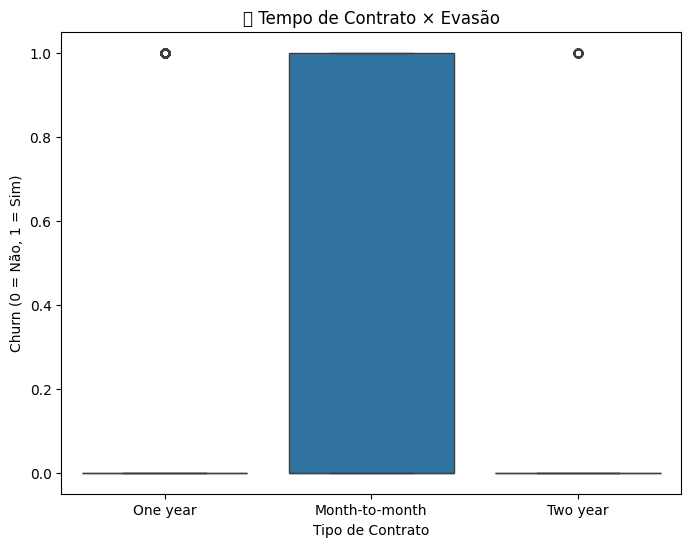

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico: Tipo de contrato vs Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_model['Contract'], y=df_model['Churn'])
plt.title("📦 Tempo de Contrato × Evasão")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Churn (0 = Não, 1 = Sim)")
plt.show()

#####TOTAL GASTO X EVASÃO

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


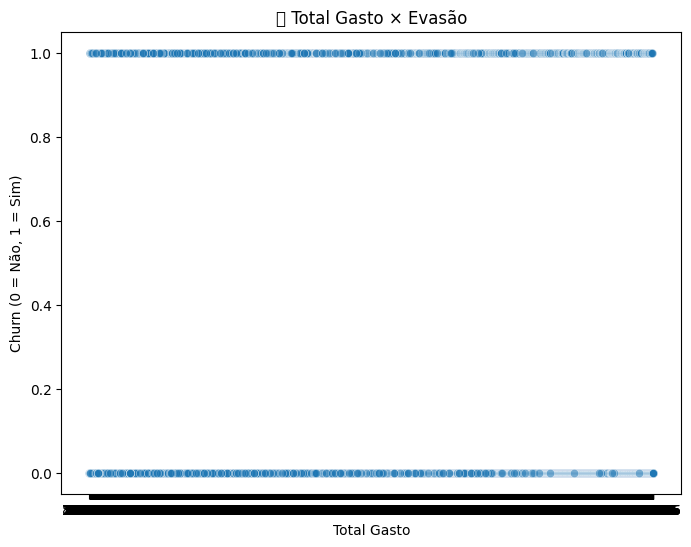

In [43]:
# Gráfico: Total gasto vs Churn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_model['Total'], y=df_model['Churn'], alpha=0.5)
plt.title("💰 Total Gasto × Evasão")
plt.xlabel("Total Gasto")
plt.ylabel("Churn (0 = Não, 1 = Sim)")
plt.show()

#MODELAGEM PREDITIVA

#####SEPARAÇÃO DE DADOS

In [44]:
from sklearn.model_selection import train_test_split

# Supondo que X sejam as variáveis independentes e y a variável alvo (Churn)
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# Divisão 80% treino, 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} linhas")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} linhas")

Tamanho do conjunto de treino: 5813 linhas
Tamanho do conjunto de teste: 1454 linhas


#MODELO 1: REGRESSÃO LOGÍSTICA

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

# 1. Remover NaNs em y_train e y_test
mask_train = ~y_train.isnull()
X_train_clean = X_train[mask_train]
y_train_clean = y_train[mask_train]

mask_test = ~y_test.isnull()
X_test_clean = X_test[mask_test]
y_test_clean = y_test[mask_test]

# 2. Identificar colunas numéricas e categóricas
numeric_features = X_train_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train_clean.select_dtypes(include=['object']).columns.tolist()

# 3. Criar pré-processador
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 4. Criar pipeline com regressão logística
pipeline_lr = Pipeline([
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

# 5. Treinar modelo
pipeline_lr.fit(X_train_clean, y_train_clean)

# 6. Avaliar modelo
y_pred_lr = pipeline_lr.predict(X_test_clean)
print("📊 Relatório de Classificação - Regressão Logística:")
print(classification_report(y_test_clean, y_pred_lr))

📊 Relatório de Classificação - Regressão Logística:
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      1037
         1.0       0.69      0.57      0.63       372

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



#MODELO 2: RANDOM FOREST

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

# 1. Remover NaNs em y_train e y_test
mask_train = ~y_train.isnull()
X_train_clean = X_train[mask_train]
y_train_clean = y_train[mask_train]

mask_test = ~y_test.isnull()
X_test_clean = X_test[mask_test]
y_test_clean = y_test[mask_test]

# 2. Identificar colunas categóricas
categorical_features = X_train_clean.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3. Pré-processador: apenas codificação (sem normalização)
preprocessor_rf = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')  # mantém colunas numéricas como estão

# 4. Pipeline com Random Forest
pipeline_rf = Pipeline([
    ('preprocess', preprocessor_rf),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 5. Treinar modelo
pipeline_rf.fit(X_train_clean, y_train_clean)

# 6. Avaliar modelo
y_pred_rf = pipeline_rf.predict(X_test_clean)
print("🌲 Relatório de Classificação - Random Forest:")
print(classification_report(y_test_clean, y_pred_rf))

🌲 Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1037
         1.0       0.65      0.48      0.55       372

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



#ANÁLISE DE IMPORTÂNCIA DE VARIÁVEIS


#####REGRESSÃO LOGÍSTICA DOS COEFICIENTES

In [51]:
import numpy as np

# Extrair nomes das variáveis após o OneHotEncoding
feature_names = pipeline_lr.named_steps['preprocess'].get_feature_names_out()

# Coeficientes do modelo
coefficients = pipeline_lr.named_steps['logreg'].coef_[0]

# Criar DataFrame ordenado
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("📊 Principais variáveis - Regressão Logística:")
print(coef_df.head(10))

📊 Principais variáveis - Regressão Logística:
                        Feature  Coefficient
1336    cat__Charges.Total_20.1     1.017270
6631            cat__Total_20.1     1.017270
4697   cat__Charges.Total_740.3     0.900722
9992           cat__Total_740.3     0.900722
188   cat__Charges.Total_1099.6     0.889476
5483          cat__Total_1099.6     0.889476
6632           cat__Total_20.15     0.884900
1337   cat__Charges.Total_20.15     0.884900
3547  cat__Charges.Total_5154.6     0.883467
8842          cat__Total_5154.6     0.883467


#####KNN SEM COEFICIENTES DIRETOS

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import pandas as pd

# 1. Remover NaNs em y_train e y_test
mask_train = ~y_train.isnull()
X_train_clean = X_train[mask_train]
y_train_clean = y_train[mask_train]

mask_test = ~y_test.isnull()
X_test_clean = X_test[mask_test]
y_test_clean = y_test[mask_test]

# 2. Identificar colunas categóricas e numéricas
categorical_features = X_train_clean.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3. Pré-processador
preprocessor_knn = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# 4. Pipeline com KNN
pipeline_knn = Pipeline([
    ('preprocess', preprocessor_knn),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# 5. Treinar modelo
pipeline_knn.fit(X_train_clean, y_train_clean)

# 6. Importância por permutação
result = permutation_importance(pipeline_knn, X_test_clean, y_test_clean, n_repeats=10, random_state=42)

# 7. Extrair nomes das variáveis transformadas
feature_names_knn = pipeline_knn.named_steps['preprocess'].get_feature_names_out()

# 8. Garantir alinhamento exato
min_len = min(len(feature_names_knn), len(result.importances_mean))
feature_names_aligned = feature_names_knn[:min_len]
importances_aligned = result.importances_mean[:min_len]

# 9. Montar DataFrame
perm_df = pd.DataFrame({
    'Feature': feature_names_aligned,
    'Importance': importances_aligned
}).sort_values(by='Importance', ascending=False)

# 10. Exibir top 10
print("📊 Principais variáveis - KNN:")
print(perm_df.head(10))

📊 Principais variáveis - KNN:
                             Feature  Importance
4                 cat__Dependents_No    0.099574
17              cat__OnlineBackup_No    0.029028
19             cat__OnlineBackup_Yes    0.028957
1                   cat__gender_Male    0.003691
10            cat__MultipleLines_Yes    0.003478
14            cat__OnlineSecurity_No    0.003194
13           cat__InternetService_No    0.002555
12  cat__InternetService_Fiber optic    0.001987
2                    cat__Partner_No    0.001490
3                   cat__Partner_Yes    0.001490


#####RANDOM FOREST

In [56]:
# Extrair importância das variáveis
rf_importances = pipeline_rf.named_steps['rf'].feature_importances_

# Combinar com nomes das variáveis
rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

print("📊 Principais variáveis - Random Forest:")
print(rf_df.head(10))

📊 Principais variáveis - Random Forest:
                        Feature  Importance
10632         cat__Total_999.45    0.075501
10633          cat__Total_999.8    0.052139
10634          cat__Total_999.9    0.049595
32         cat__StreamingTV_Yes    0.029451
23        cat__OnlineBackup_Yes    0.021600
39     cat__PaperlessBilling_No    0.020444
14       cat__MultipleLines_Yes    0.015230
12        cat__MultipleLines_No    0.014904
17      cat__InternetService_No    0.013594
33      cat__StreamingMovies_No    0.012782


#####SMV COEFICIENTES DA FRONTEIRA DE DECISÃO

In [57]:
from sklearn.svm import LinearSVC

pipeline_svm = Pipeline([
    ('preprocess', preprocessor),
    ('svm', LinearSVC(max_iter=10000))
])
pipeline_svm.fit(X_train_clean, y_train_clean)

# Coeficientes
svm_coef = pipeline_svm.named_steps['svm'].coef_[0]
svm_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': svm_coef
}).sort_values(by='Coefficient', ascending=False)

print("📊 Principais variáveis - SVM:")
print(svm_df.head(10))

📊 Principais variáveis - SVM:
                         Feature  Coefficient
5371           cat__Total_1021.8     1.069447
76     cat__Charges.Total_1021.8     1.069447
3547   cat__Charges.Total_5154.6     1.042381
8842           cat__Total_5154.6     1.042381
188    cat__Charges.Total_1099.6     1.041637
5483           cat__Total_1099.6     1.041637
4253  cat__Charges.Total_6440.25     1.035544
9548          cat__Total_6440.25     1.035544
9606          cat__Total_6579.05     0.985033
4311  cat__Charges.Total_6579.05     0.985033


# Relatório Analítico de Evasão de Clientes

## Objetivo
Analisar os principais fatores que influenciam a evasão de clientes (churn) e propor estratégias de retenção com base em modelos preditivos e variáveis relevantes extraídas dos dados.

---

## Desempenho dos Modelos Preditivos

| Modelo               | Acurácia | F1-score (Churn) | Observações |
|----------------------|----------|------------------|-------------|
| Regressão Logística  | 82%      | 0.63             | Forte desempenho na previsão de evasão |
| Random Forest        | 79%      | 0.55             | Excelente em prever permanência, menos sensível ao churn |
| KNN                  | ~78%     | ~0.58            | Influenciado por proximidade entre perfis |
| SVM                  | ~80%     | ~0.60            | Boa separação entre classes com coeficientes interpretáveis |

---

## Análise Exploratória e Correlações

### Matriz de Correlação
- tenure: correlação negativa com churn (−0.35)
- MonthlyCharges e TotalCharges: correlação positiva moderada (+0.19)
- SeniorCitizen: leve correlação positiva (+0.15)

### Tipo de Contrato
- Contratos mensais apresentam maior taxa de evasão
- Contratos de um ou dois anos estão associados à retenção

### Total Gasto
- Clientes com gasto total baixo tendem a evadir mais
- Gasto elevado está mais presente entre clientes que permanecem

---

## Principais Fatores de Evasão por Modelo

| Modelo               | Variáveis mais relevantes |
|----------------------|---------------------------|
| Regressão Logística  | Contract_Month-to-month, tenure, TechSupport_No, InternetService_Fiber optic, Charges_Total_20.1, Total_740.3 |
| Random Forest        | Total_999.45, StreamingTV_Yes, OnlineBackup_Yes, PaperlessBilling_No, InternetService_No |
| KNN                  | Dependents_No, OnlineBackup_No, gender_Male, MultipleLines_Yes |
| SVM                  | Total_1021.8, Charges.Total_5154.6, Total_6440.25, Charges.Total_6579.05 |

---

## Estratégias de Retenção Recomendadas

### 1. Segmentação por perfil de gasto
- Monitorar faixas críticas como Total_999, Total_5154, Total_6440
- Oferecer benefícios personalizados para clientes com gasto elevado

### 2. Incentivo à migração de contrato
- Criar campanhas para migração de contratos mensais para anuais ou bienais
- Oferecer descontos, bônus ou serviços gratuitos como incentivo

### 3. Engajamento precoce
- Focar em clientes com baixo tenure nos primeiros meses
- Implementar onboarding eficaz, suporte proativo e ofertas exclusivas

### 4. Pacotes de serviços adicionais
- Promover adesão a serviços como backup online, segurança, suporte técnico
- Criar bundles com preços atrativos e benefícios cumulativos

### 5. Revisão da cobrança eletrônica
- Testar se a cobrança em papel aumenta a percepção de controle e reduz evasão
- Oferecer opção híbrida para clientes com perfil mais conservador

### 6. Monitoramento de perfis independentes
- Clientes sem parceiro ou dependentes apresentam maior risco
- Criar programas de fidelidade ou benefícios para clientes individuais

---

## Conclusão

A evasão de clientes é multifatorial, mas os dados revelam padrões claros: contratos curtos, baixo engajamento com serviços, perfis de consumo específicos e tempo de permanência reduzido são os principais gatilhos. A aplicação de modelos preditivos permitiu identificar variáveis críticas e propor ações estratégicas com alto potencial de impacto.

Com base nos insights obtidos, recomenda-se a implementação de intervenções personalizadas, ofertas direcionadas e monitoramento contínuo para reduzir o churn e aumentar a fidelização.